In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *

from remkit.load import load_remkit
# from code_comparison.code_comparison import *

from cycler import cycler
mpl.rcParams["axes.prop_cycle"] = cycler("color", ["teal", "darkorange", "firebrick", "limegreen", "darkorchid", "deeppink", 
                                                   "#1E90FF", "forestgreen", "#4169e1", "darkgoldenrod", "#9370db", "crimson", "#2f4f4f" ])


%load_ext autoreload
%autoreload 2

# Intro
- This PR makes sure that processes that depend on collisions get the right ones
- Conduction should only take ee or ii into account
- Diffusion should only take CX and IZ into account
- Neutral viscosity should take CX and IZ 
- Ion viscosity should take ii 

# IO

In [2]:
cs = dict()

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    # dict(name="add_bndry_fix", id="sc12ac-add_bndry_flux_fix", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="gamma_3.5", id="sc12ad-gamma_i_3.5", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="no_force_balance", id="sc12af-no_force_balance", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="disable_laxflux_heating", id="sc12afg-disable_laxflux_heating", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="no_vi", id="sc12b-gamma3.5_nofbalance_vi0", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="no_viscosity", id="sc12ah-disable_ion_viscosity", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="enable_sound_speed", id="sc12ai-enable_sound_speed", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="scale_fastestwave_0.5", id="sc12aj-scale_fastestwave_0.5", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="scale_fastestwave_0.1", id="sc12aja-scale_fastestwave_0.1", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="scale_fastestwave_0.05", id="sc12ajb-scale_fastestwave_0.05", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="scale_fastestwave_0.0", id="sc12ajc-scale_fastestwave_0.0", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="laxon", id="sc13b-forcebalance_on_scalewave_1", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="laxflux_x0.05", id="sc12b-forcebalance_on_scalewave_0.05", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxflux_off", id="sc12ba-forcebalance_on_scalewave_0.0", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    
    # dict(name="laxflux_off_fixflux_off", id="sc12baa-forcebalance_on_scalewave_0.0_fixfluxoff", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxon_fixflux_off", id="sc13bb-laxfluxon_fixfluxoff", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    
    # dict(name="laxon_fixfluxoff_loggrid", id="sc13bc-laxfluxon_fixfluxoff_loggrid", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="laxon_fixfluxoff_loggrid_freeNe", id="sc13bcd-laxfluxon_fixfluxoff_loggrid_free_ne", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxon_fixfluxoff_loggrid_freeNePe", id="sc13bce-laxfluxon_fixfluxoff_loggrid_free_ne_pe", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxon_fixfluxoff_loggrid_LinearFreeNePe", id="sc13bcf-laxfluxon_fixfluxoff_loggrid_linearfree_ne_pe", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    
    # dict(name="laxon_fixfluxon_loggrid_freeNePe", id="sc13bdb-laxfluxon_fixfluxon_loggrid_free_ne_pe", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxon_fixfluxon_loggrid_LinearFreeNePe", id="sc13bdc-laxfluxon_fixfluxon_loggrid_linearfree_ne_pe", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    
    # dict(name="laxon_fixfluxon", id="sc13b-forcebalance_on_scalewave_1", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxon_fixfluxon_freeNePe", id="sc14a-laxflux_fixfluxon_free_all", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="lax0.05_fixfluxon_freeNePe", id="sc14ac-laxflux0.05_fixfluxon_free_all", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxon_fixfluxoff_freeNePe", id="sc14ab-laxflux_fixfluxoff_free_all", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxon_fixfluxon_loggrid", id="sc13bc-laxfluxon_fixfluxoff_loggrid", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    
    # dict(name="laxon_fixfluxon", id="sc13b-forcebalance_on_scalewave_1", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxon_fixfluxon_freeNePe", id="sc14a-laxflux_fixfluxon_free_all", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="laxon_fixfluxon_LinFreeNePe", id="sc15a-laxflux_fixfluxon_linear_free_all", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Log grid versions
    # dict(name="default", id="sc13bc-laxfluxon_fixfluxoff_loggrid", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="freeNePe", id="sc13bce-laxfluxon_fixfluxoff_loggrid_free_ne_pe", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="LinearFreeNePe", id="sc13bcf-laxfluxon_fixfluxoff_loggrid_linearfree_ne_pe", unnormalise_geom = True, use_xhermes = True, guard_replace = False), 
    # dict(name="LinearFreeNePe_fixfluxOn", id="sc13bdc-laxfluxon_fixfluxon_loggrid_linearfree_ne_pe", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    
    # Ben test cases
    # dict(name="base", id="bl5a-ben_neutrals", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="freeExp", id="bl5ab-freeexp_all", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="freeLin", id="bl5ac-freelin_all", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="freeLin_fluxfix_off", id="bl5acb-freelin_all_fixflux_off", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # dict(name="base", id="bl5acbc-test_old_flux_names", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    # dict(name="test", id="bl5acbb-test_new_flux_names", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    
    # Adding complexity
    dict(name="lofidelity_base", id="sc13bcf-laxfluxon_fixfluxoff_loggrid_linearfree_ne_pe", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
    dict(name="add_qei", id="sc16a-13bcf_add_Qei", unnormalise_geom = True, use_xhermes = True, guard_replace = False),
]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"])
    cs[case["name"]].ds.load()


/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


## ReMKiT1D

### Read wrapper pickle file to know what model is being run
- This is required to know how to read the HDF5 files

In [3]:
rkcs = {}
wrappers = {}

# rkcs["restart"] = load_remkit(  
#                    hdf5Filepath = "/ssd_scratch/compare_data/rk2_restart_from_sc12ac",
#                    wrapperPickleFilename = "/ssd_scratch/compare_data/rk2_restart_from_sc12ac/RMK_hermes3-sc12ac-add_bndry_flux_fix.pkl",
#                    numFiles = 2
#                     )

# name = "bndry_flux_fix"
# wrappers[name], rkcs[name] = load_remkit(  
#                    hdf5Filepath = "/ssd_scratch/compare_data/RMK_hermes3-add_bndry_flux_fix/RMK_hermes3-add_bndry_flux_fix",
#                    wrapperPickleFilename = "/ssd_scratch/compare_data/RMK_hermes3-add_bndry_flux_fix/RMK_hermes3-sc12ac-add_bndry_flux_fix.pkl",
#                    numFiles = 8
#                     )

name = "gamma_3.5"
wrappers[name], rkcs[name] = load_remkit(  
                   hdf5Filepath = "/ssd_scratch/compare_data/RMK_hermes3-sc12ac-add_bndry_flux_fix-no-kin/RMK_hermes3-add_bndry_flux_fix",
                   wrapperPickleFilename = "/ssd_scratch/compare_data/RMK_hermes3-sc12ac-add_bndry_flux_fix-no-kin/RMK_hermes3-sc12ac-add_bndry_flux_fix-no-kin.pkl",
                   numFiles = 8
                    )

# Target heat balance

In [4]:
ds = cs["gamma_3.5"].ds.isel(t=-1)

bal = Balance1D(ds, verbose = False, override_vi = True)
bal.get_terms()
bal.sheath
sh = bal.sheath

hrhbal = {}
hrhbal["e_sheath_gamma"] = bal.gamma_e * sh["pfe"] * sh["te"] * constants("q_e") / sh["da"] * 1e-6
hrhbal["e_sheath_kin"] = sh["hfe"] / sh["da"] - hrhbal["e_sheath_gamma"]
hrhbal["e_sheath_tot"] = sh["hfe"] / sh["da"]

hrhbal["i_sheath_gamma"] = (bal.gamma_i - 1) * sh["pfi"] * sh["ti"] * constants("q_e") / sh["da"] * 1e-6 
hrhbal["i_sheath_kin"] = (sh["hfi"] / sh["da"] - hrhbal["i_sheath_gamma"]) 
hrhbal["i_sheath_tot"] = sh["hfi"] / sh["da"]

####### ReMKiT1D

name = "gamma_3.5"
rk = rkcs[name].isel(time=-1)
wrapper = wrappers[name]
last = rk.isel(x=-1)
grid = wrapper.grid
dx = grid.xWidths[-1]   # Normalised parallel grid widths

rkhbal = {}
rkhbal["e_sheath_gamma"] = last["bohmBoundary_e_energy_BCGamma"] * dx
rkhbal["e_sheath_kin"] = last["bohmBoundary_e_energy_BCKin"] * dx
rkhbal["e_sheath_tot"] = rkhbal["e_sheath_gamma"] + rkhbal["e_sheath_kin"]

rkhbal["i_sheath_gamma"] = last["bohmBoundary_i_energy_BCGamma"] * dx
if "bohmBoundary_i_energy_BCKin" in last:
    rkhbal["i_sheath_kin"] = last["bohmBoundary_i_energy_BCKin"] * dx
else:
    rkhbal["i_sheath_kin"] = np.nan
rkhbal["i_sheath_tot"] = rkhbal["i_sheath_gamma"] + rkhbal["i_sheath_kin"]

for param in rkhbal:
    if type(rkhbal[param]) == xr.DataArray:
        rkhbal[param] = rkhbal[param].values

KeyError: 'gamma_3.5'

In [22]:
print("Sheath fluxes [MW/m2]")
print("::::::::::::::::::::::::::::\n")
df = pd.DataFrame()

for param in ["Ne", "Te", "Td+"]:
    if param == "Ne":
        factor = 1/1e19
    else:
        factor = 1
        
    df.loc[param, "ReMKiT1D"] = rk[f"{param}_dual"].values[-1] * factor
    df.loc[param, "Hermes-3"] = ((ds.isel(pos=-2)[param] + ds.isel(pos=-3)[param]) /2).values * factor
    
df.loc["Cs", :] = np.sqrt((df.loc["Te"] + df.loc["Td+"]) * constants("q_e") / bal.Mi) 
df.loc[param, "Hermes-3"] = ((ds.isel(pos=-2)[param] + ds.isel(pos=-3)[param]) /2).values * factor

df.loc["Pe"] = df.loc["Te"] * df.loc["Ne"] * 1e19 * constants("q_e")
df.loc["Pd+"] = df.loc["Td+"] * df.loc["Ne"] * 1e19 * constants("q_e")

for param in rkhbal:
    
    df.loc[param, "ReMKiT1D"] = rkhbal[param]
    df.loc[param, "Hermes-3"] = hrhbal[param]
    
    # print(param)
    # print(f"--ReMKiT1D: {rkhbal[param]:.3f}")
    # print(f"--Hermes-3: {hrhbal[param]:.3f}")
    # # print("Difference:", rkhbal[param] - hrhbal[param])
    # # print("Relative difference:", (rkhbal[param] - hrhbal[param]) / hrhbal[param])

df = df.rename({"Ne" : "Ne x 1e19"}, axis = 0)

# df["Ratio"] = df["ReMKiT1D"] / df["Hermes-3"]
display_dataframe(df, format = "{:.3f}", greyout = False)

Sheath fluxes [MW/m2]
::::::::::::::::::::::::::::



,ReMKiT1D,Hermes-3
Ne x 1e19,6.394,4.743
Te,4.081,5.003
Td+,4.595,6.425
Cs,20384.874,23394.954
Pe,41.808,38.019
Pd+,47.078,48.822
e_sheath_gamma,-4.000,-4.003
e_sheath_kin,-0.000,0.000
e_sheath_tot,-4.000,-4.003
i_sheath_gamma,-4.000,-2.855


In [252]:
Cs_ratio = df.loc["Cs", "ReMKiT1D"] / df.loc["Cs", "Hermes-3"]
Pe_ratio = df.loc["Pe", "Hermes-3"] / df.loc["Pe", "ReMKiT1D"]
Pi_ratio = df.loc["Pd+", "Hermes-3"] / df.loc["Pd+", "ReMKiT1D"]

print(Cs_ratio)
print(Pe_ratio)
print(Pi_ratio)

0.89962138354468
0.9322293134728737
0.9795858865810473


In [239]:
((ds.isel(pos=-2)["Vd+"] + ds.isel(pos=-3)["Vd+"]) /2).values * factor

0.0

In [194]:
4.083/5.352

0.7628923766816144

In [28]:
ld.dims

Frozen({'x': 512, 'h': 1, 'v': 1, 'time': 2, 'dim_0': 1})

# Profiles

# Convergence

In [7]:
cs.keys()

dict_keys(['laxon_fixfluxoff_freeNePe'])

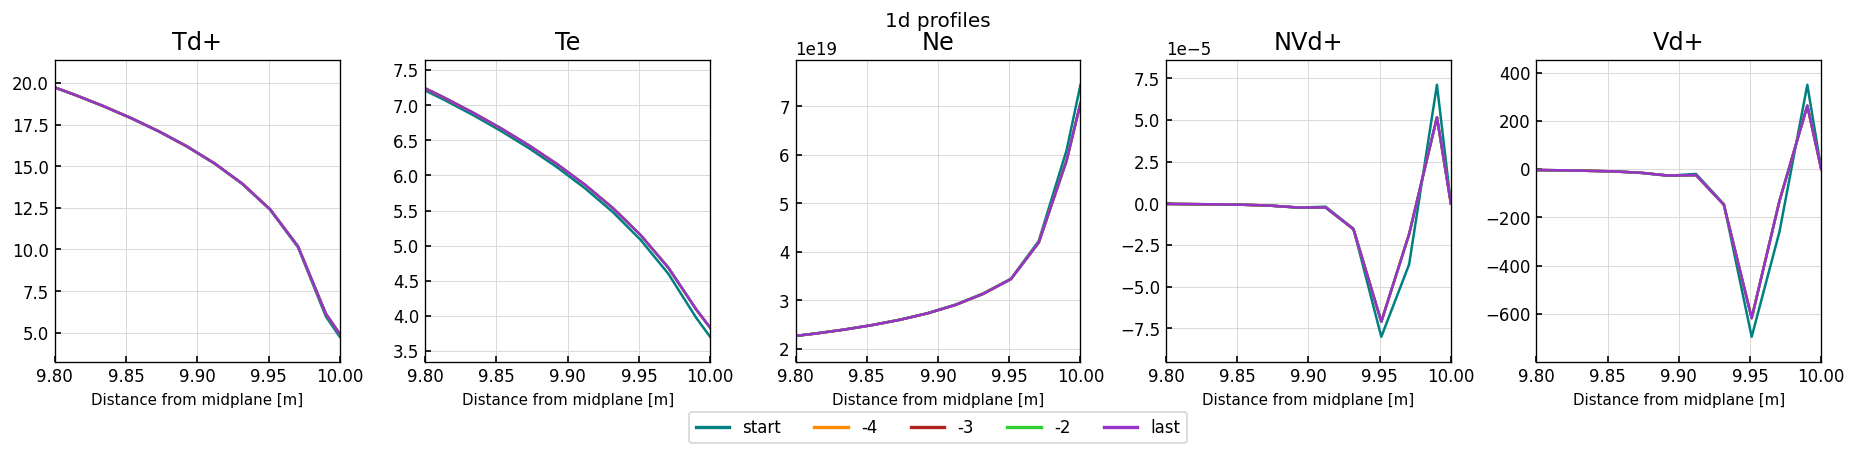

In [9]:
case = "laxon_fixfluxoff_freeNePe"

lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-4":cs[case].ds.isel(t=-4),
        "-3":cs[case].ds.isel(t=-3),
        "-2":cs[case].ds.isel(t=-2),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = False,
    guard_replace = True,
    params = ["Td+", "Te", "Ne", "NVd+", "Vd+"],
    regions = ["1d"],
    lw = 1.5,
    markersize = 0,
    # xlims = (29.5, 30.02)
    xlims=(9.8,10.0)
)

# Hermes/Remkit profiles

NameError: name 'rkcs' is not defined

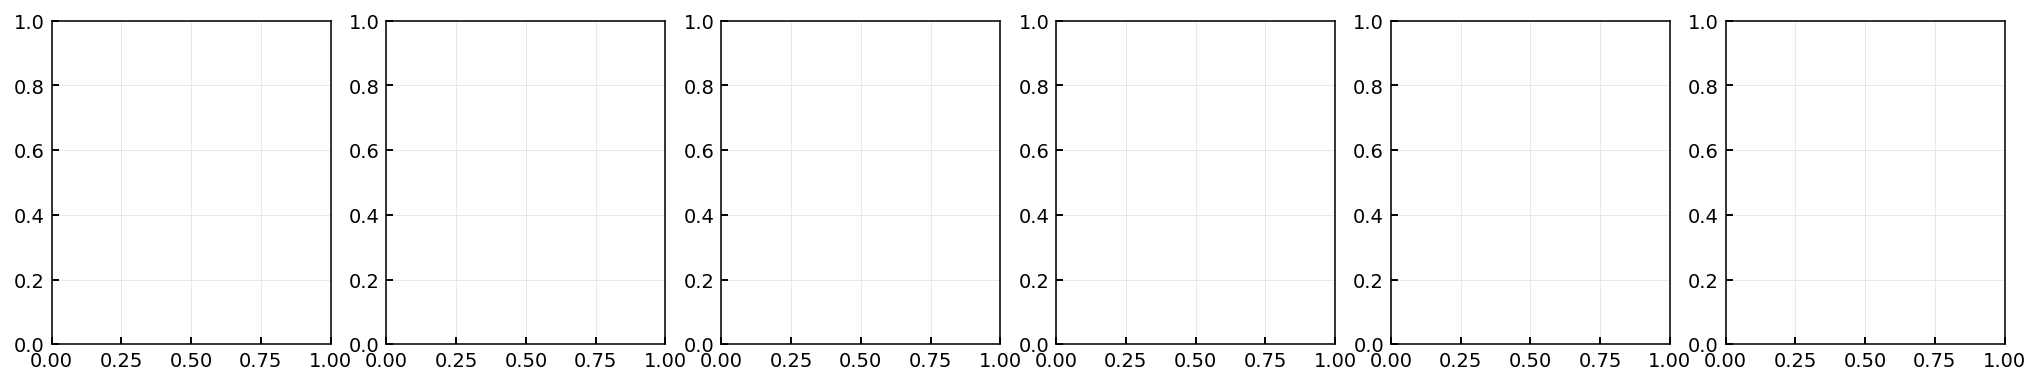

In [3]:
list_params = ["Ne", "Te", "Td+", "Pe", "Pd+",  "Vd+"]
# list_params = ["Ne", "Vd+"]
# list_params = ["Pe", "Pd+", "We", "Wi"]

fig, axes = plt.subplots(1,len(list_params), figsize = (len(list_params)*3,3))


ranges = {"Ne" : (1.5e19, 6.5e19), "Te" : (3, 8), "Td+" : (4, 25)}   # Target
# ranges = {"Ne" : (0.695e19, 0.71e19), "Te" : (22, 23), "Td+" : (62, 66)}  # Upstream
# ranges = {"Ne" : (None, None), "Te" : (None, None), "Td+" : (None, None)}

for case in cs:
    cs[case].ds["P"] = cs[case].ds["Pe"] + cs[case].ds["Pd+"]
    
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, param in enumerate(list_params):

    ax = axes[i]
    
    hrstyle = dict(marker = "o", ms = 2)
    
    for j, case in enumerate(rkcs):
        rk = rkcs[case].isel(time=-1)
        if param in rk:
            ax.plot(rk["x"], rk[param], label = f"ReMKiT1D: {case}" if i == 0 else "", lw = 0, marker = "o", ms = 2, c = colors[len(cs) + j], zorder = 100)
    
    for j, case in enumerate(cs):
        ds = cs[case].ds.isel(t=-1, pos = slice(2,-2))
        if param in ds:
            ax.plot(ds["pos"], ds[param], label=f"Hermes-3: {case}" if i == 0 else "", **hrstyle, c = colors[j])

        
    ax.set_title(param)
    ax.set_xlim(9.7,10.02)   # Target
    # ax.set_xlim(-0.05,0.25)    # upstream
    if param in ranges.keys():
        ax.set_ylim(ranges[param])
    
fig.legend(loc = "upper center", ncol = 1, bbox_to_anchor=(0.5,0), ncols = 2)

# Hermes-3 case comparison

In [5]:
cs.keys()

dict_keys(['LinearFreeNePe_fixfluxOn'])

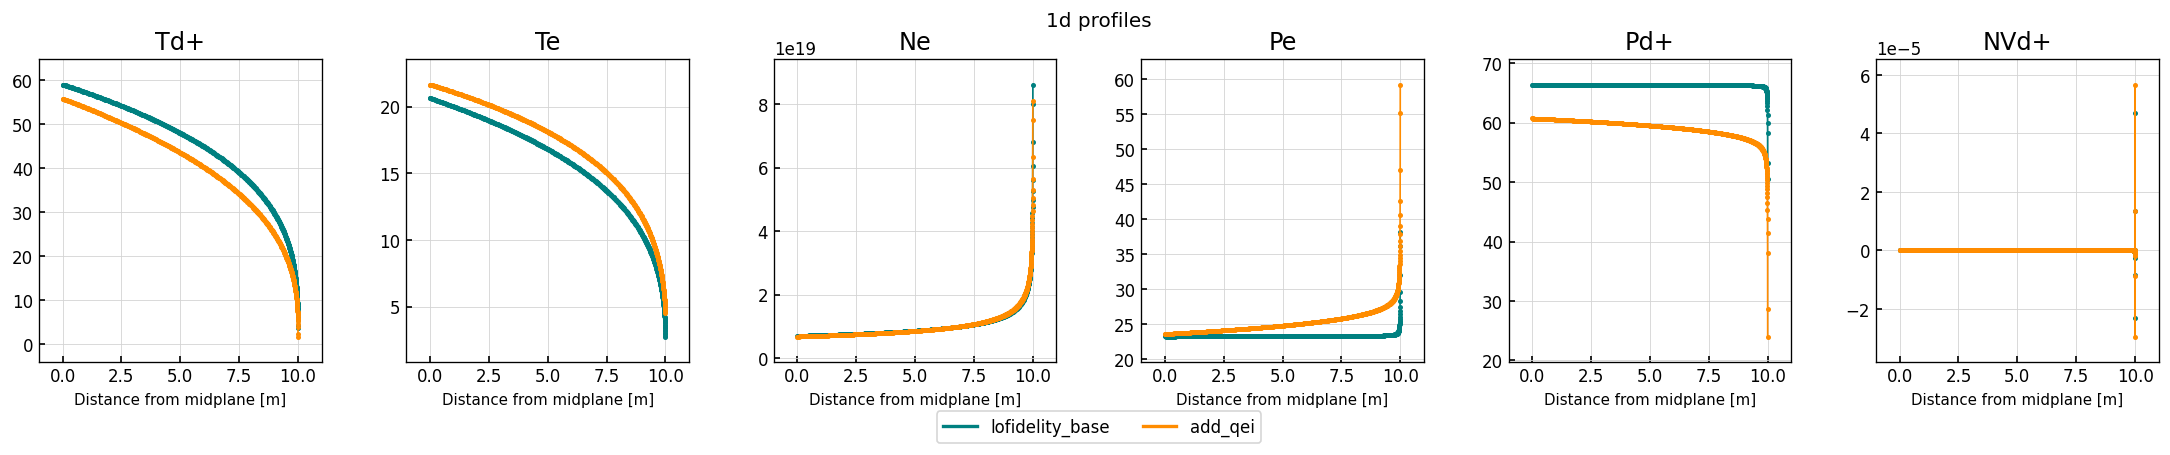

In [5]:
toplot = {}
for name in cs:
# for name in ["freeNePe"]:
    ds = cs[name].ds
    if "t" in ds.dims:
        ds = ds.isel(t=-1)
    toplot[name] = ds

lineplot(
    toplot,
    clean_guards = False,
    guard_replace = True,
    logscale = False,
    params = ["Td+", "Te", "Ne", "Pe", "Pd+", "NVd+"],
    # params = ["Vd+"],
    regions = ["1d"],
    lw = 1,
    # xlims=(9.8,10.01)
    # xlims = (9.98,10.005),
    # xlims = (29.6, 30.05)
    # xlims=(-0.1,1.5)
)

In [5]:
cs.keys()

dict_keys(['LinearFreeNePe'])

In [6]:
ds = cs["LinearFreeNePe_fixfluxOn"].ds.isel(t=-1)

ds["NVd+"].values[-5:]

array([-5.44750908e-06,  9.32394270e-05, -4.78945121e-04,  3.40281490e-03,
        0.00000000e+00])

In [73]:
ds = cs["laxon_fixfluxoff_loggrid"].ds.isel(t=-1)

da = ds["NVd+"]

print("\nroginal:")
print(da.values[-5:])

da = da.copy()
    # da[-2] = (da[-2] + da[-3])/2
# da[1] = (da[1] + da[2])/2

da[{"pos" : -2}] = (da[{"pos" : -3}] + da[{"pos" : -2}])/2
da[{"pos" : 1}] = (da[{"pos" : 1}] + da[{"pos" : 2}])/2

da = da.isel(pos = slice(1, -1))

print("\nGuard replaced:")
print(da.values[-5:])

# print(guard_replace_1d(ds["NVd+"]).values[-5:])

print("\nIn ds:")
print(ds["NVd+"].values[-5:])


roginal:
[-1.97368670e-05  9.31363532e-05  1.79321924e-04 -1.79321924e-04
  0.00000000e+00]

Guard replaced:
[-1.07495851e-05 -1.97368670e-05  9.31363532e-05  1.79321924e-04
  0.00000000e+00]

In ds:
[-1.97368670e-05  9.31363532e-05  1.79321924e-04 -1.79321924e-04
  0.00000000e+00]


In [7]:
cs.keys()

dict_keys(['laxon_fixfluxoff_loggrid_freeNePe', 'laxon_fixfluxon_loggrid_freeNePe'])

Text(0.5, 1.0, '')

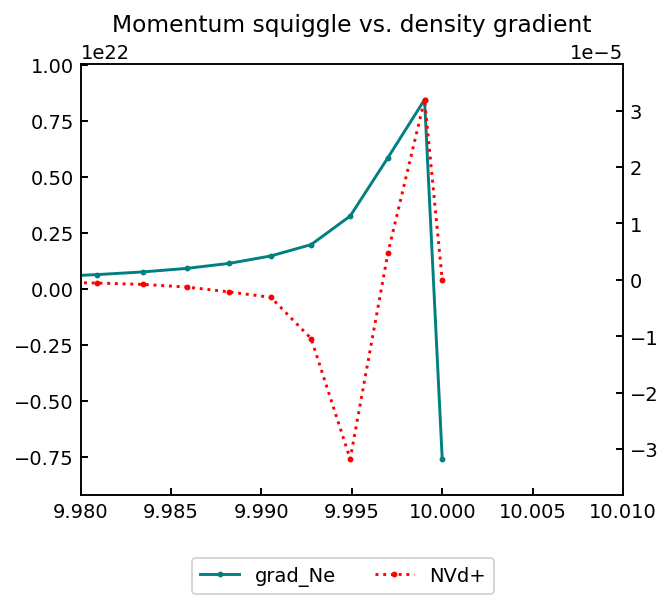

In [8]:
ds = cs["laxon_fixfluxoff_loggrid_freeNePe"].ds.isel(t=-1)

fig, ax = plt.subplots()
ax2 = ax.twinx()

ngrad = ds["Ne"].differentiate("pos").values

pos = guard_replace_1d(ds["pos"].values)
ngrad = guard_replace_1d(ngrad)
NVi = guard_replace_1d(ds["NVd+"])

ax.plot(pos, ngrad, label = "grad_Ne", marker = "o", ms = 2)
# guard_replace_1d(ds["NVd+"]).plot(ax = ax2, label = "NVd+", color = "red", marker = "o", ms = 2, ls = ":")


ax2.plot(pos, NVi, label = "NVd+", color = "red", marker = "o", ms = 2, ls = ":")

fig.legend(loc="upper center", bbox_to_anchor = (0.5, 0), ncols = 2)
ax.set_xlim(9.98,10.01)
ax.grid(False)
ax2.grid(False)
ax.set_title("Momentum squiggle vs. density gradient")
ax2.set_title("")

In [17]:
ds["NVd+"].values[-5:]

array([-1.97368670e-05,  3.66997431e-05,  1.79321924e-04,  1.34491443e-04,
        0.00000000e+00])

In [138]:
for case in cs:
    ds = cs[case].ds.isel(t=-1, pos = slice(2,-2))
    integral = (ds["Ne"] * ds["dv"]).sum()
    print(f"{case}: {integral:.9e}")
    

enable_sound_speed: 6.283185085e+20
scale_fastestwave_0.5: 6.283184886e+20
scale_fastestwave_0.1: 6.283184900e+20
scale_fastestwave_0.05: 6.283184914e+20
scale_fastestwave_0.0: 6.283184914e+20


# CVODE performance

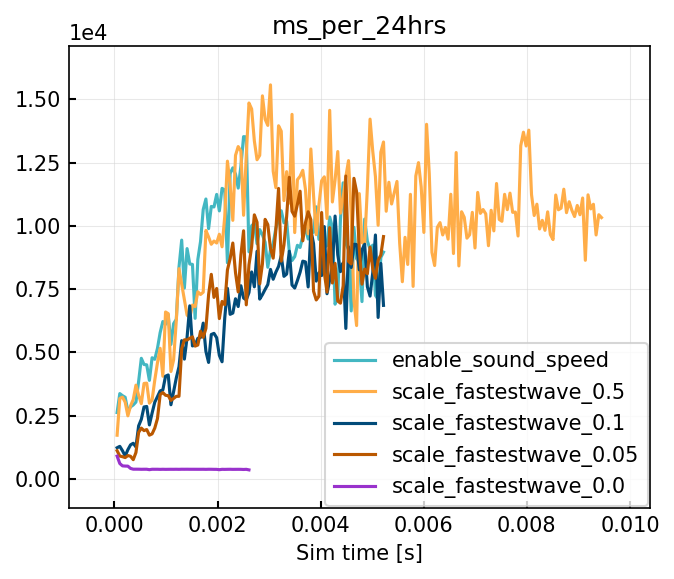

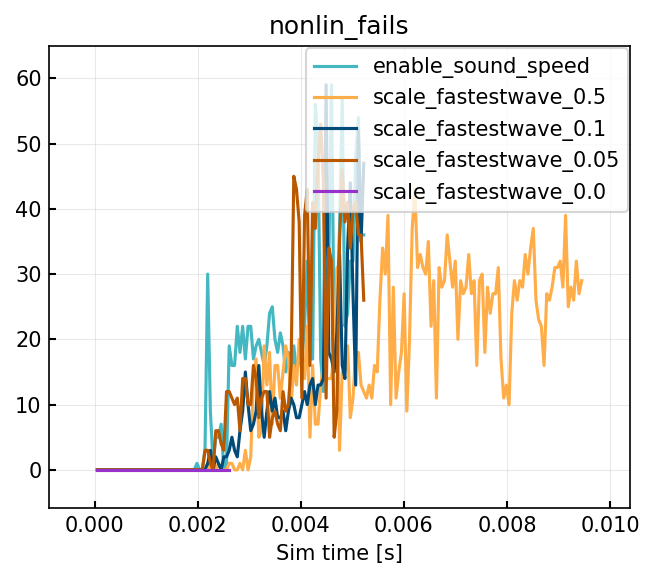

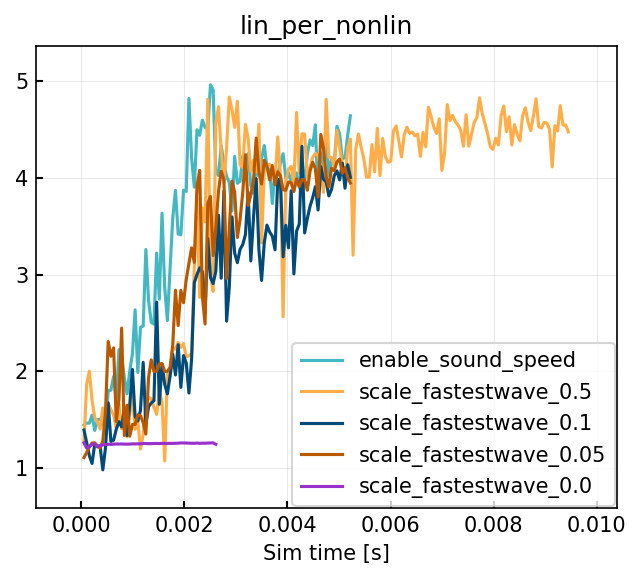

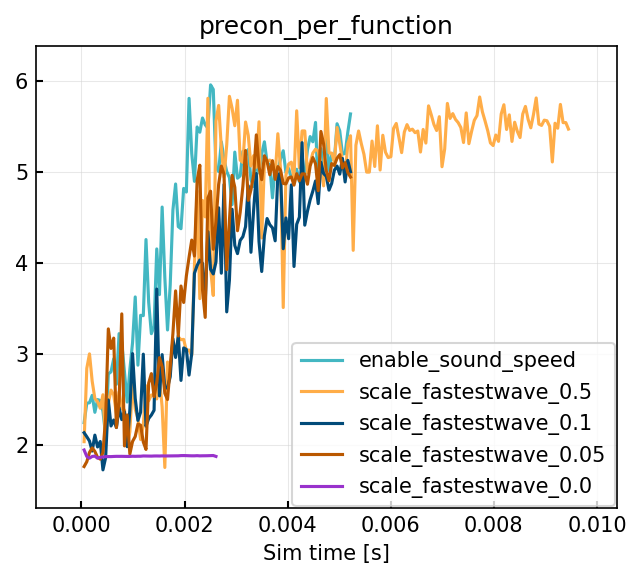

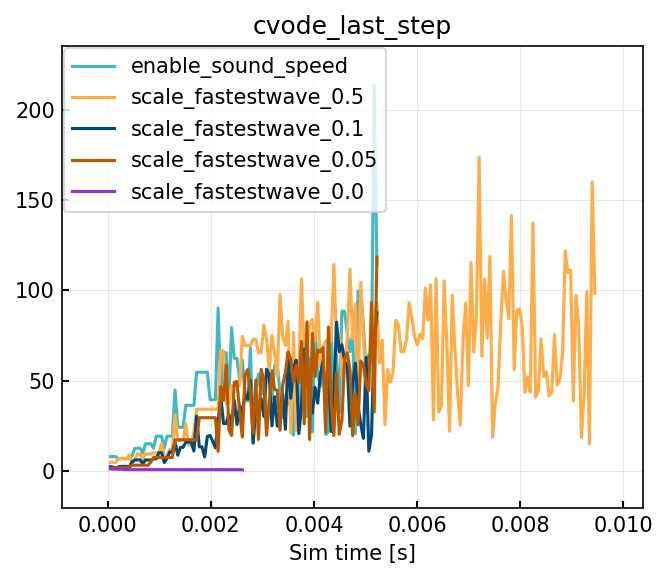

In [134]:
dict_ds = {}
[dict_ds.update({name: cs[name].ds}) for name in cs]
plot_cvode_performance(dict_ds, logscale = False)

In [33]:
cs["gamma_3.5"].ds["NVd+"].isel(t=-1).values[-5:]

array([ 3.79621720e-06,  6.74782467e-05,  1.44219674e-04, -1.44219674e-04,
        0.00000000e+00])

# Check guards

In [60]:
cs.keys()

dict_keys(['laxon_fixflux_off', 'laxon_fixfluxoff_loggrid', 'test'])

In [10]:
# ds  = cs["test"].ds
# if "t" in ds.dims: ds = ds.isel(t=-1)
# unnormalise = True

# if unnormalise is True:
#     mp = constants("mass_p")
#     me = constants("mass_e")
#     qe = constants("q_e")
# else:
#     mp = 1
#     me = 1
#     qe = 1

# gamma_e = ds.options["sheath_boundary_simple"]["gamma_e"]
# gamma_i = ds.options["sheath_boundary_simple"]["gamma_i"]

def limitFree(fm, fc):
    #  Limited free gradient of log of a quantity
    #  This ensures that the guard cell values remain positive
    #  while also ensuring that the quantity never increases
    # 
    #   fm  fc | fp
    #          ^ boundary
    # 
    #  exp( 2*log(fc) - log(fm) )
    # 

    if fm < fc:
        return  fc    # Neumann
        
    if fm < 1e-10:
        return fc
    
    return  (fc**2 / fm).values

def limitFree(fm, fc, mode):
    #  Limited free gradient of log of a quantity
    #  This ensures that the guard cell values remain positive
    #  while also ensuring that the quantity never increases
    # 
    #   fm  fc | fp
    #          ^ boundary
    # 
    #  exp( 2*log(fc) - log(fm) )
    # 

    if fm < fc and mode == 0:
        return  fc    # Neumann
        
    if fm < 1e-10:
        return fc
    
    if mode == 0 or mode == 1:
        return fc**2 / fm
    elif mode == 2:
        return 2*fc - fm
    else:
        raise ValueError("Mode must be 0, 1 or 2")
    


In [13]:
mode = 2

previous = ds.isel(pos=-4)
last = ds.isel(pos=-3)
guard = ds.isel(pos=-2)
dom = ds.isel(pos = slice(2,-2))   # Domain

ne_guard = limitFree(previous["Ne"], last["Ne"], mode)
ti_guard = limitFree(previous["Td+"], last["Td+"], mode)
te_guard = limitFree(previous["Te"], last["Te"], mode)
pe_guard = limitFree(previous["Pe"], last["Pe"], mode)
pi_guard = limitFree(previous["Pd+"], last["Pd+"], mode)

print(f"Ne_guard: model = {guard['Ne']:.4e},  calc = {ne_guard:.4e}")
print(f"Ti_guard: model = {guard['Td+']:.4e},  calc = {ti_guard:.4e}")
print(f"Te_guard: model = {guard['Te']:.4e},  calc = {te_guard:.4e}")
print(f"Pi_guard: model = {guard['Pd+']:.4e},  calc = {pi_guard:.4e}")
print(f"Pe_guard: model = {guard['Pe']:.4e},  calc = {pe_guard:.4e}")
print(f"NVi_guard: model = {guard['Pe']:.4e},  calc = {pe_guard:.4e}")


Ne_guard: model = 8.8550e+18,  calc = 8.8550e+18
Ti_guard: model = 1.1902e+01,  calc = 1.1902e+01
Te_guard: model = 9.7578e+00,  calc = 9.7578e+00
Pi_guard: model = 1.6431e+01,  calc = 1.6431e+01
Pe_guard: model = 1.3822e+01,  calc = 1.3822e+01


In [63]:
Nnorm = ds.metadata["Nnorm"]
Ne_last = last["Ne"] / Nnorm
Ne_previous = previous["Ne"] / Nnorm
Ne_guard = ne_guard / Nnorm

print(f"Ne_guard:      {Ne_guard:.2f}")
print(f"Ne_last:       {Ne_last:.2f}")
print(f"Ne_previous:   {Ne_previous:.2f}")

Ne_guard:      7504.50
Ne_last:       7504.50
Ne_previous:   6623.18


In [1]:
cs.keys()

NameError: name 'cs' is not defined

In [ ]:
cs["LinearFreeNePe_fixfluxOn"].ds.data_vars

KineticFlow_d+_ylow
KineticFlow_e_ylow
KineticFlow_d_ylow
ConductionFlow_d+_ylow
ConductionFlow_e_ylow
ConductionFlow_d_ylow
EnergyFlow_d+_ylow
EnergyFlow_e_ylow
EnergyFlow_d_ylow
EnergyFlow_total_ylow


KeyError: 'EnergyFlow_total_ylow'

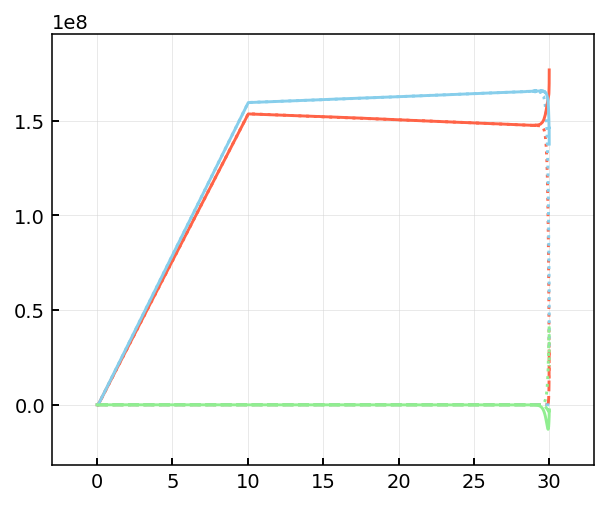

In [34]:

color_ion = "tomato"
color_electron = "skyblue"
color_neutral = "lightgreen"
style_kin = dict(ls = "--")
style_total = dict(ls = "-")
style_cond = dict(ls = ":")

ds["EnergyFlow_total_ylow"] = ds["EnergyFlow_d+_ylow"] + ds["EnergyFlow_e_ylow"] + ds["EnergyFlow_d_ylow"]

fluxes = {
    "KineticFlow_d+_ylow" : dict(label = "ion kinetic",      color = color_ion, style = style_kin),
    "KineticFlow_e_ylow" : dict(label = "electron kinetic",  color = color_electron, style = style_kin),
    "KineticFlow_d_ylow" : dict(label = "neutral kinetic",   color = color_neutral, style = style_kin),
    "ConductionFlow_d+_ylow" : dict(label = "ion conduction", color = color_ion, style = style_cond),
    "ConductionFlow_e_ylow" : dict(label = "electron conduction", color = color_electron, style = style_cond),
    "ConductionFlow_d_ylow" : dict(label = "neutral conduction", color = color_neutral, style = style_cond),
    "EnergyFlow_d+_ylow" : dict(label = "ion total", color = color_ion, style = style_total),
    "EnergyFlow_e_ylow" : dict(label = "electron total", color = color_electron, style = style_total),
    "EnergyFlow_d_ylow" : dict(label = "neutral total", color = color_neutral, style = style_total),
    "EnergyFlow_total_ylow" : dict(label = "total flow", color = "black", style = style_total),
}

# Sources of energy. To be summed along field line
sources = [
    ("Pd+_src", "Ion external source", 3./2),
    ("Pe_src", "Electron external source", 3./2),
    ("Rd+_ex", "Excitation radiation", 1.0),
    ("Rd+_rec", "Recombination losses", 1.0),
]

ds = cs["freeLin_fluxfix_off"].ds
pos = guard_replace_1d(ds["pos"].values)

if "t" in ds.dims: ds = ds.isel(t=-1)

fig, ax = plt.subplots()
for name in fluxes:
    settings = fluxes[name]
    print(name)
    ax.plot(pos, guard_replace_1d(ds[name]), label = settings["label"], color = settings["color"], **settings["style"])

# for _, value in source_data.items():
#     ax.plot(ds["pos"].values[2:-1], value[0], label = value[1], linestyle='--')
    
ax.legend(loc = "upper left", bbox_to_anchor = (1,1))
ax.set_ylabel('MW')
# ax.set_xlim(9.95,10.01)
ax.set_xlim(29.5,30.05)
ax.set_xlabel("Pos [m]")



Text(0.5, 0, 'Pos [m]')

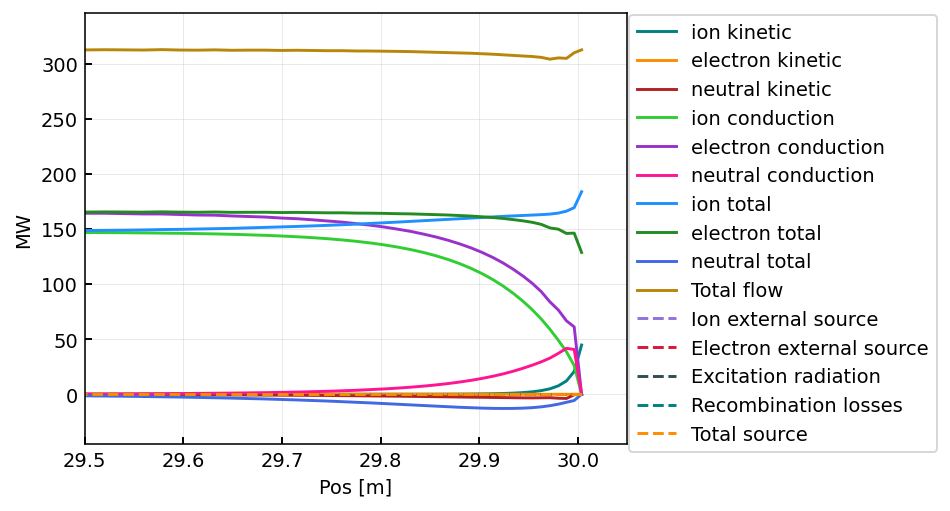

In [10]:
ds = cs["freeLin_fluxfix_off"].ds

if "t" in ds.dims: ds = ds.isel(t=-1)

if len(sys.argv) != 2:
    print("Usage: {} path".format(sys.argv[0]))
    sys.exit(1)

path = sys.argv[1]

# These diagnostics describe parallel flows of energy
flows = [
    ("KineticFlow_d+_ylow", "ion kinetic"),
    ("KineticFlow_e_ylow", "electron kinetic"),
    ("KineticFlow_d_ylow", "neutral kinetic"),
    ("ConductionFlow_d+_ylow", "ion conduction"),
    ("ConductionFlow_e_ylow", "electron conduction"),
    ("ConductionFlow_d_ylow", "neutral conduction"),
    ("EnergyFlow_d+_ylow", "ion total"),
    ("EnergyFlow_e_ylow", "electron total"),
    ("EnergyFlow_d_ylow", "neutral total"),
]

# Sources of energy. To be summed along field line
sources = [
    ("Pd+_src", "Ion external source", 3./2),
    ("Pe_src", "Electron external source", 3./2),
    ("Rd+_ex", "Excitation radiation", 1.0),
    ("Rd+_rec", "Recombination losses", 1.0),
    #("Edd+_cx", "CX d -> d+", -1.0),
    #("Ed+_iz", "IZ d -> d+", 1.0),
    #("SPd+", "SPd+", 3./2),
    #("SPe", "SPe", 3./2),
]


dV = ds["dv"].values[2:-2]
    
def remove_guards(var1D):
    return var1D[2:-1]

flow_data = {}
total_flow = 0
for name, label in flows:
    if name in ds:
        value = ds[name].values.copy() * 1e-6
    else:
        print(f"Flow {name} not found")
        continue
    # Convert to MW
    this_flow = remove_guards(value)
    flow_data[name] = (this_flow,
                       label)
    if name[0] == 'E':
        # Energyflow
        total_flow += this_flow

flow_data["total"] = (total_flow,
                      "Total flow")

source_data = {}
total_source = 0.0
for name, label, factor in sources:
    if name in ds:
        value = ds[name].values.copy() * factor * 1e-6
    else:
        print(f"Source {name} not found")
        continue
        
    value 

    value[2:-2] *= dV
    value = value[1:-2]
    value[0] = 0.0 # No influx from lower boundary
    this_source = np.cumsum(value)
    source_data[name] = (this_source,
                         label)
    total_source += this_source
source_data["total"] = (total_source,
                        "Total source")

fig, ax = plt.subplots()
for _, value in flow_data.items():
    ax.plot(ds["pos"].values[2:-1], value[0], label = value[1])

for _, value in source_data.items():
    ax.plot(ds["pos"].values[2:-1], value[0], label = value[1], linestyle='--')
    
ax.legend(loc = "upper left", bbox_to_anchor = (1,1))
ax.set_ylabel('MW')
# ax.set_xlim(9.95,10.01)
ax.set_xlim(29.5,30.05)
ax.set_xlabel("Pos [m]")


Text(0.5, 1.0, 'Ne')

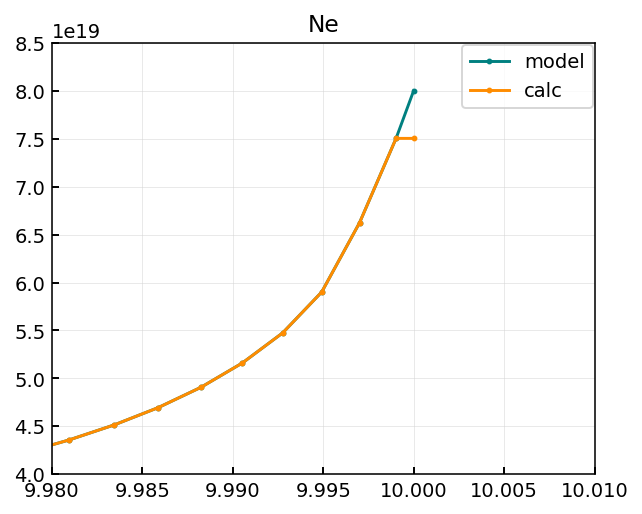

In [64]:
calc_Ne = ds["Ne"].values.copy()
calc_Ne[-2] = ne_guard
calc_Ne = guard_replace_1d(calc_Ne)
pos = guard_replace_1d(ds["pos"].values)

fig, ax = plt.subplots()
style = dict(marker = "o", ms = 2)
ax.plot(pos, guard_replace_1d(ds["Ne"]), label = "model", **style)
ax.plot(pos, calc_Ne, label = "calc", **style)

ax.set_xlim(9.98,10.01)
ax.set_ylim(4e19, 8.5e19)
ax.legend()
ax.set_title("Ne")

# Flux plots

In [31]:
cs.keys()

dict_keys(['freeExp', 'freeLin', 'freeLin_fluxfix_off'])

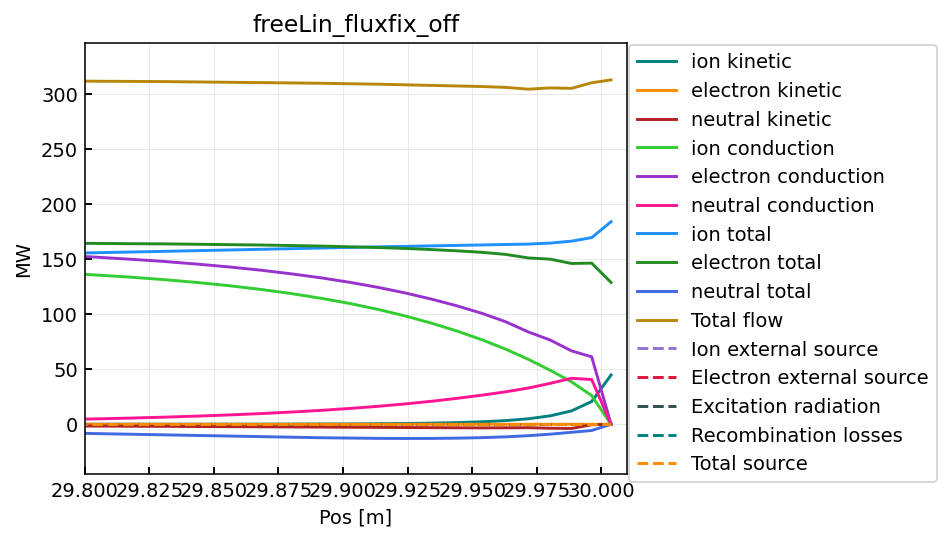

In [36]:
for name in ["freeLin_fluxfix_off"]:
    ds = cs[name].ds
    bal = Balance1D(ds, verbose = False, override_vi = True)
    bal.plot_flux_balance2(xlims = (29.8, 30.01), title = name)

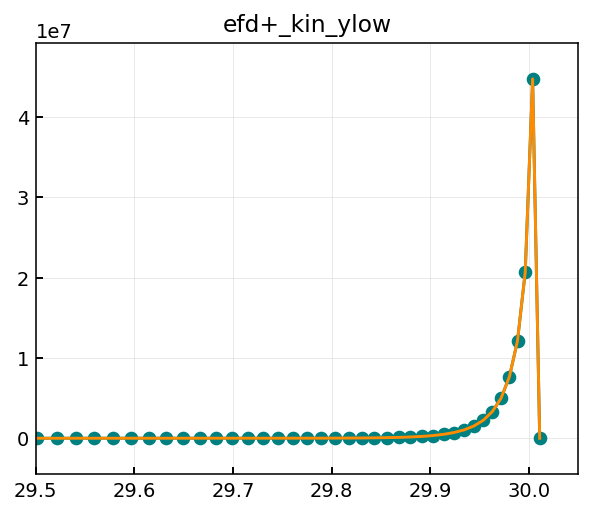

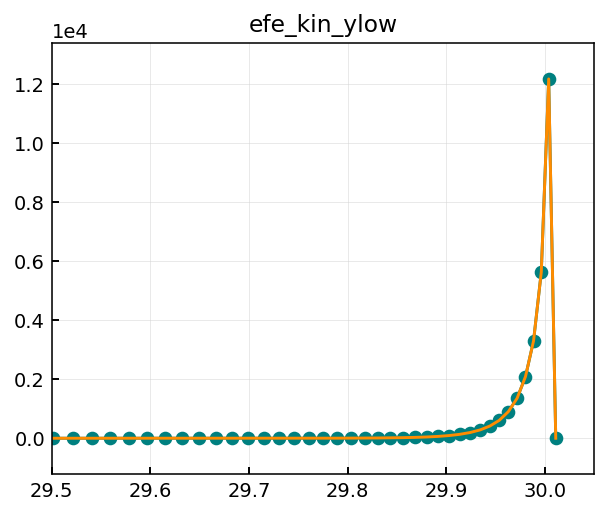

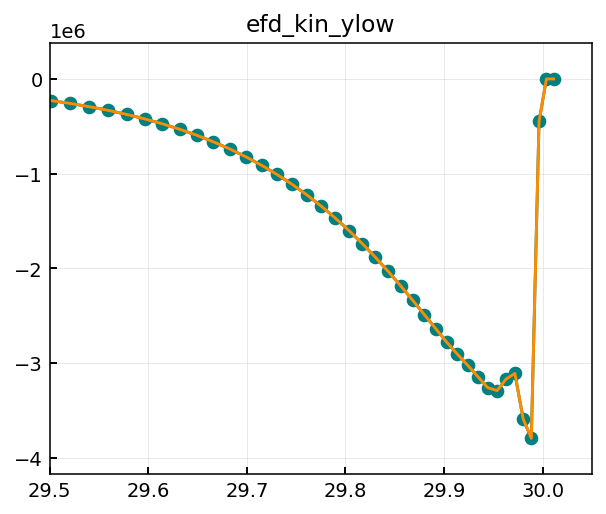

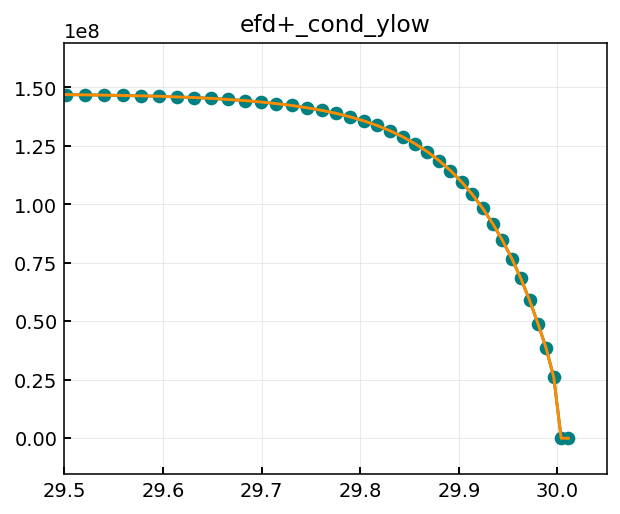

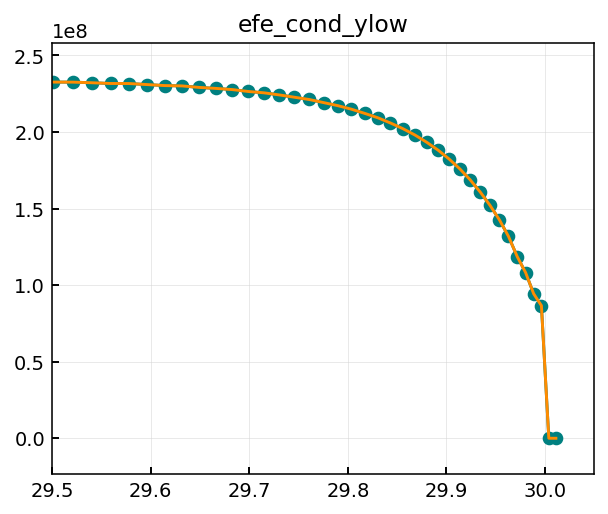

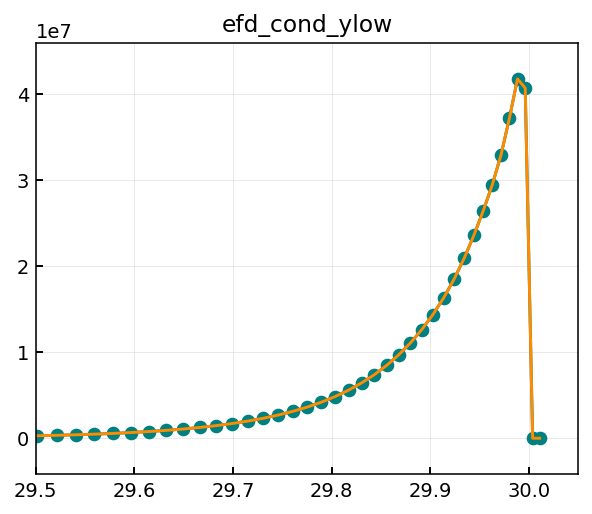

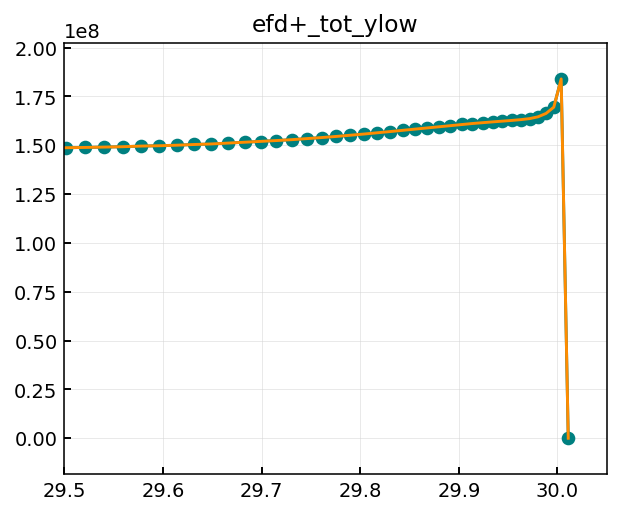

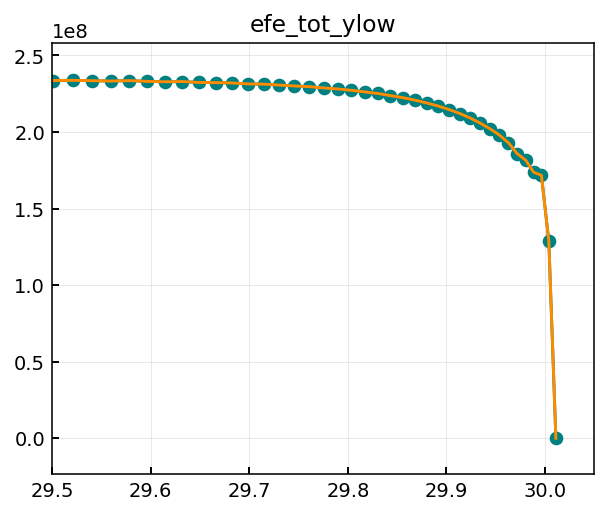

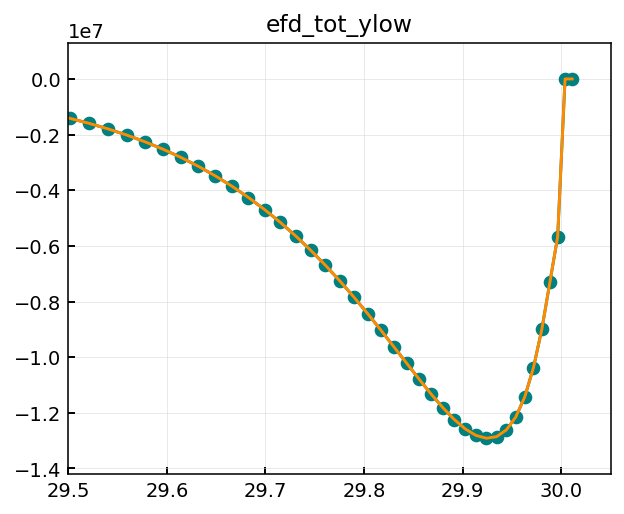

In [29]:

params = [
    ("efd+_kin_ylow", "KineticFlow_d+_ylow"),
    ("efe_kin_ylow", "KineticFlow_e_ylow"),
    ("efd_kin_ylow", "KineticFlow_d_ylow"),
    ("efd+_cond_ylow", "ConductionFlow_d+_ylow"),
    ("efe_cond_ylow", "ConductionFlow_e_ylow"),
    ("efd_cond_ylow", "ConductionFlow_d_ylow"),
    ("efd+_tot_ylow", "EnergyFlow_d+_ylow"),
    ("efe_tot_ylow", "EnergyFlow_e_ylow"),
    ("efd_tot_ylow", "EnergyFlow_d_ylow")
]

dsnew = cs["test"].ds
dsold = cs["base"].ds

for new, old in params:
    fig, ax = plt.subplots()
    ax.plot(dsnew["pos"], dsnew[new], label = "new", marker = "o")
    ax.plot(dsold["pos"], dsold[old], label = "old")
    ax.set_title(new)
    ax.set_xlim(29.5,30.05)
    


In [26]:
1.6*3/2

2.4000000000000004

efd+_kin_ylow
efe_kin_ylow
efd_kin_ylow
efd+_cond_ylow
efe_cond_ylow
efd_cond_ylow
efd+_tot_ylow
efe_tot_ylow
efd_tot_ylow
total


NameError: name 'xlims' is not defined

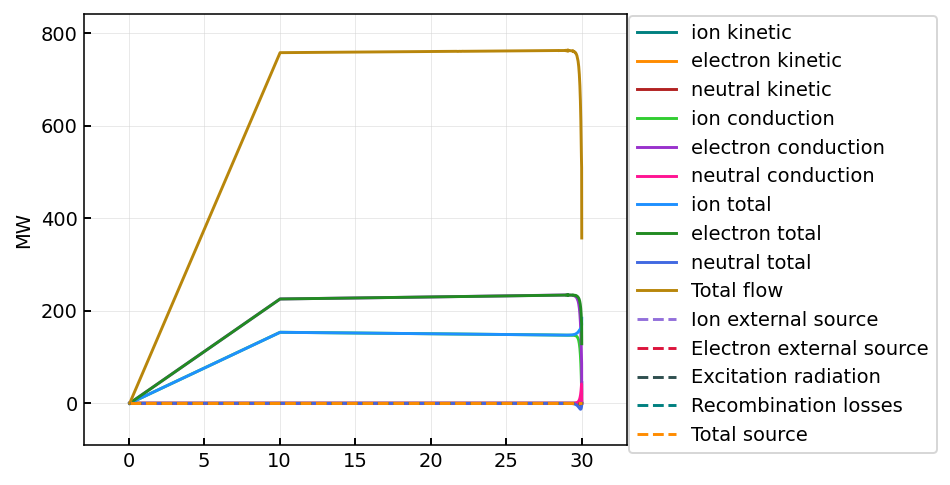

In [19]:

if "t" in ds.dims: ds = ds.isel(t=-1)


if len(sys.argv) != 2:
    print("Usage: {} path".format(sys.argv[0]))
    sys.exit(1)

path = sys.argv[1]

# These diagnostics describe parallel flows of energy
# flows = [
#     ("KineticFlow_d+_ylow", "ion kinetic"),
#     ("KineticFlow_e_ylow", "electron kinetic"),
#     ("KineticFlow_d_ylow", "neutral kinetic"),
#     ("ConductionFlow_d+_ylow", "ion conduction"),
#     ("ConductionFlow_e_ylow", "electron conduction"),
#     ("ConductionFlow_d_ylow", "neutral conduction"),
#     ("EnergyFlow_d+_ylow", "ion total"),
#     ("EnergyFlow_e_ylow", "electron total"),
#     ("EnergyFlow_d_ylow", "neutral total"),
# ]

flows = [
    ("efd+_kin_ylow", "ion kinetic"),
    ("efe_kin_ylow", "electron kinetic"),
    ("efd_kin_ylow", "neutral kinetic"),
    ("efd+_cond_ylow", "ion conduction"),
    ("efe_cond_ylow", "electron conduction"),
    ("efd_cond_ylow", "neutral conduction"),
    ("efd+_tot_ylow", "ion total"),
    ("efe_tot_ylow", "electron total"),
    ("efd_tot_ylow", "neutral total"),
]


# Sources of energy. To be summed along field line
sources = [
    ("Pd+_src", "Ion external source", 3./2),
    ("Pe_src", "Electron external source", 3./2),
    ("Rd+_ex", "Excitation radiation", 1.0),
    ("Rd+_rec", "Recombination losses", 1.0),
    #("Edd+_cx", "CX d -> d+", -1.0),
    #("Ed+_iz", "IZ d -> d+", 1.0),
    #("SPd+", "SPd+", 3./2),
    #("SPe", "SPe", 3./2),
]


dV = ds["dv"].values[2:-2]
    
def remove_guards(var1D):
    return var1D[2:-1]

flow_data = {}
total_flow = 0
for name, label in flows:
    if name in ds:
        value = ds[name].values
    else:
        print(f"Flow {name} not found")
        continue
    # Convert to MW
    this_flow = remove_guards(value * 1e-6)
    flow_data[name] = (this_flow,
                    label)
    if name[0] == 'e':
        # Energyflow
        total_flow += this_flow

flow_data["total"] = (total_flow,
                    "Total flow")

source_data = {}
total_source = 0.0
for name, label, factor in sources:
    if name in ds:
        value = ds[name].values
    else:
        print(f"Source {name} not found")
        continue
        
    value *= factor * 1e-6

    value[2:-2] *= dV
    value = value[1:-2]
    value[0] = 0.0 # No influx from lower boundary
    this_source = np.cumsum(value)
    source_data[name] = (this_source,
                        label)
    total_source += this_source
source_data["total"] = (total_source,
                        "Total source")

fig, ax = plt.subplots()
for name, value in flow_data.items():
    print(name)
    ax.plot(ds["pos"].values[2:-1], value[0], label = value[1])

for name, value in source_data.items():
    ax.plot(ds["pos"].values[2:-1], value[0], label = value[1], linestyle='--')
    
ax.legend(loc = "upper left", bbox_to_anchor = (1,1))
ax.set_ylabel('MW')

if xlims != (None, None):
    ax.set_xlim(xlims)
ax.set_xlabel("Pos [m]")
ax.set_title(title)


In [18]:
flow_data["total"]

(0, 'Total flow')

## hermes

Text(0, 0.5, 'MW')

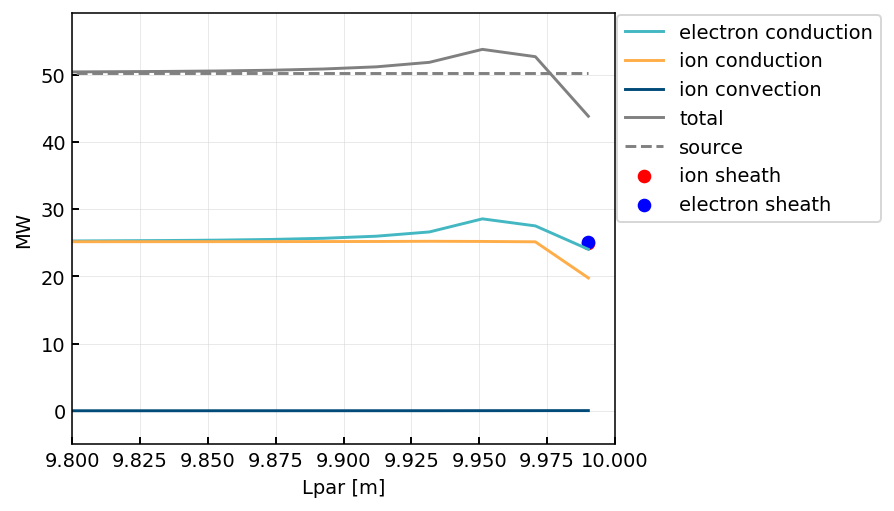

In [132]:
ds = cs["no_outflow_fix_minmod"].ds.isel(t=-1, pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_conv = ds["Vd+"] * ds["Pd+"] * 3/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

fig, ax = plt.subplots()
ax.plot(ds["pos"], hfe_cond, label = "electron conduction")
ax.plot(ds["pos"], hfi_cond, label = "ion conduction")
ax.plot(ds["pos"], hfi_conv, label = "ion convection")
ax.plot(ds["pos"], hf_tot, c = "grey", label = "total")
ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")



ax.scatter([ds["pos"][-1].data], [hfi_sheath[-1].data*-1], c = "red", label = "ion sheath")
ax.scatter([ds["pos"][-1].data], [hfe_sheath[-1].data*-1], c = "blue", label = "electron sheath")

ax.set_ylim(-5, ax.get_ylim()[1])
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
ax.set_xlim(9.8,10.0)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("MW")

In [116]:
ds = self.ds
qe = self.qe
Zi = self.Zi
Mi = self.Mi
Me = self.Me
Ge = self.Ge
sheath_ion_polytropic = self.sheath_ion_polytropic
phi_wall = self.phi_wall

dasheath = self.get_target_value(ds["da"])
dv = ds.isel(pos=-3)["dv"].values

visheath = self.get_target_value(ds["Vd+"])
vesheath = self.get_target_value(ds["Ve"])

nesheath = self.get_target_value(ds["Ne"])
nisheath = self.get_target_value(ds["Nd+"])

tesheath = self.get_target_value(ds["Te"])
tisheath = self.get_target_value(ds["Td+"])

cssheath = np.sqrt((sheath_ion_polytropic * tisheath*qe + Zi * tesheath*qe) / Mi)   # [m/s] Bohm criterion sound speed

ion_sum = Zi * nisheath * cssheath   # Sheath current
phisheath = tesheath * np.log(np.sqrt(tesheath / (Me * 2*np.pi)) * (1 - Ge) * nesheath / ion_sum)   # [V] sheath potential, (note Neumann BC)
vesheath = np.sqrt(tesheath / (2*np.pi * Me)) * (1 - Ge) * np.exp(-(phisheath - phi_wall)/tesheath)

pfi_sheath = -1 * cssheath * nisheath * dasheath   # [s^-1] ion particle flux into domain 
pfe_sheath = -1 * vesheath * nesheath * dasheath   # [s^-1] electron particle flux into domain 

# hfi_sheath = pfi_sheath * (self.gamma_i * tisheath*qe + 0.5*Mi*cssheath**2) * 1e-6   # [MW] electron heat flux into domain
# hfe_sheath = pfe_sheath * (self.gamma_e * tesheath*qe + 0.5*Me*vesheath**2) * 1e-6   # [MW] electron heat flux into domain

hfi_sheath = pfi_sheath * self.gamma_i * tisheath*qe * 1e-6   # [MW] electron heat flux into domain
hfe_sheath = pfe_sheath * self.gamma_e * tesheath*qe * 1e-6   # [MW] electron heat flux into domain

print(f"hfi_sheath = {hfi_sheath[-1]:.3f}")
print(f"hfe_sheath = {hfe_sheath[-1]:.3f}")

hfi_sheath = -25.012
hfe_sheath = -25.074


## Remkit comparison - flux as diagnostic variable

Text(0, 0.5, 'MW / m2')

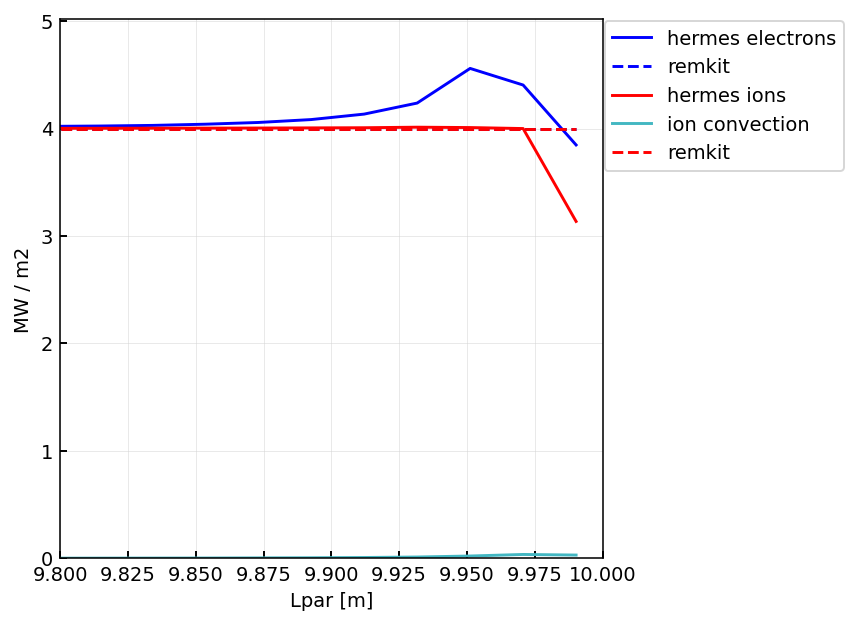

In [101]:
ds = cs["no_outflow_fix_minmod_fixboundary"].ds.isel(t=-1,  pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * -1e-6 #* 1e-2
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * -1e-6 #* 1e-2
hfi_conv = ds["Vd+"] * ds["Pd+"] * 3/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

fig, ax = plt.subplots(figsize = (5,5))
ax.plot(ds["pos"], hfe_cond, c = "blue", label = "hermes electrons")
ax.plot(ld["x"], ld["qe"].isel(time=-1), c = "blue", ls = "--", label = "remkit")
ax.plot(ds["pos"], hfi_cond, c = "red", label = "hermes ions")
ax.plot(ds["pos"], hfi_conv, label = "ion convection")
# ax.plot(ds["pos"], hf_tot, c = "grey", label = "total")

ax.plot(ld["x"], ld["qi"].isel(time=-1), c = "red", ls = "--", label = "remkit")
# ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")

ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
ax.set_xlim(9.8,10.0)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("MW / m2")

## Remkit comparison - flux calculated from grad(T)

In [143]:
rk_kappa_e.shape

(512, 512)

Text(0, 0.5, 'MW / m2')

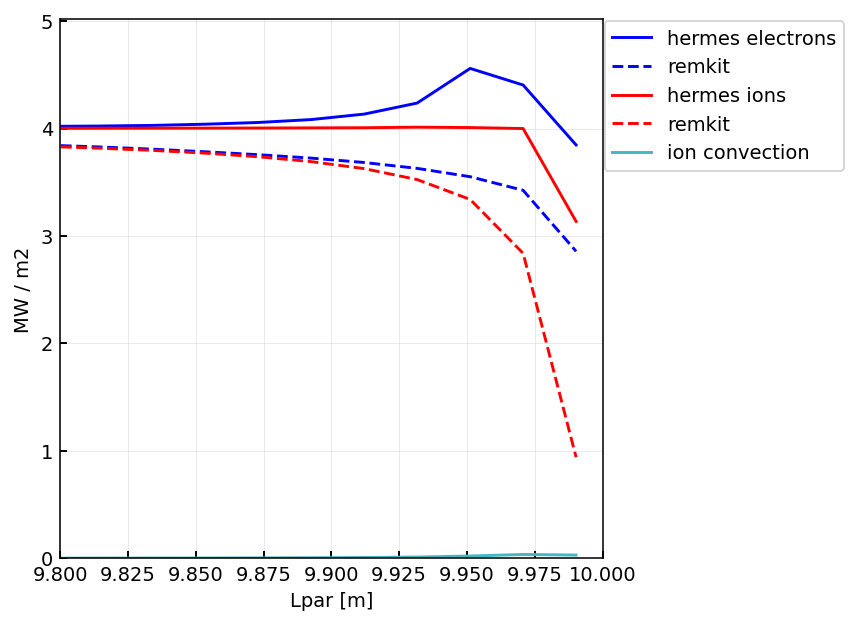

In [149]:
if "time" in ld.dims:
    ld = ld.isel(time=-1)

ds = cs["no_outflow_fix_minmod_fixboundary"].ds.isel(t=-1,  pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * -1e-6 #* 1e-2
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * -1e-6 #* 1e-2
hfi_conv = ds["Vd+"] * ds["Pd+"] * 3/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

rk_kappa_e = ds["kappa_par_e"].data * ld["Te_dual"].data**(5/2) / ds["Te"].data**(5/2)
rk_kappa_i = ds["kappa_par_d+"].data * ld["Ti_dual"].data**(5/2) / ds["Td+"].data**(5/2)

hfe_cond_rk = rk_kappa_e * np.gradient(ld["Te"], ld["x"]) * -1e-6 
hfi_cond_rk = rk_kappa_i * np.gradient(ld["Ti"], ld["x"]) * -1e-6 

fig, ax = plt.subplots(figsize = (5,5))
ax.plot(ds["pos"], hfe_cond, c = "blue", label = "hermes electrons")
ax.plot(ld["x"], hfe_cond_rk, c = "blue", ls = "--", label = "remkit")

ax.plot(ds["pos"], hfi_cond, c = "red", label = "hermes ions")
ax.plot(ld["x"], hfi_cond_rk, c = "red", ls = "--", label = "remkit")

ax.plot(ds["pos"], hfi_conv, label = "ion convection")
# ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")

ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
ax.set_xlim(9.8,10.0)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("MW / m2")

In [ ]:
ds = cs["no_outflow_conddiags"].ds.isel(t=-1, pos = slice(2,-2))

src = ((ds["Pd+_src"] + ds["Pe_src"]) * ds["dv"]).sum("pos") * 1e-6 * 3/2

# hfe_cond = 2293.8117*ds["Te"]**(5/2)*np.gradient(ds["Te"], ds["pos"]) * -1e-6
hfe_cond = ds["kappa_par_e"] * np.gradient(ds["Te"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_cond = ds["kappa_par_d+"] * np.gradient(ds["Td+"], ds["pos"]) * ds["da"] * -1e-6 #* 1e-2
hfi_conv = ds["Vd+"] * ds["Pd+"] * 5/2  * 1e-6
hf_tot = hfe_cond + hfi_cond + hfi_conv

# hfe_cond2 = scipy.integrate.cumulative_trapezoid(ds["ConductionDiv_e_par"], ds["pos"], initial = 0) * ds["da"] * -1e-6 
hfi_cond = (ds["ConductionDiv_d+_par"] * ds["dv"]).cumsum("pos") * -1e-6 * 3/2
hfe_cond = (ds["ConductionDiv_e_par"] * ds["dv"]).cumsum("pos") * -1e-6 * 3/2

fig, ax = plt.subplots()
ax.plot(ds["pos"], hfe_cond, label = "electron conduction")
ax.plot(ds["pos"], hfi_cond, label = "ion conduction")
ax.plot(ds["pos"], hfi_conv, label = "ion convection")
ax.plot(ds["pos"], hf_tot, c = "grey", label = "total")
# ax.hlines(src, ds["pos"][0], ds["pos"][-1], label = "source", colors = "grey", linestyle = "--")
# ax.set_ylim(-5, ax.get_ylim()[1])
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
# ax.set_xlim(9.8,10.0)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("MW")

# Export

In [6]:
cs.keys()

dict_keys(['lofidelity_base', 'add_qei'])

In [7]:
ds = cs['add_qei'].ds.isel(pos = slice(2,-2), t = -1)

df = pd.DataFrame()
df.index = ds["pos"].values
df.index.name = "y"

for param in ["Ne", "Nd", "Pe", "Pd+", "Pe", "Te", "Td+", "Td"]:
    if param in ds:
        df[param] = ds[param].values
    else:
        df[param] = np.nan


df["NVd+"] = ds["NVd+"] / (constants("mass_p")*2)

if "NVd" in ds:
    df["NVd"] = ds["NVd"] / (constants("mass_p")*2)
else:
    df["NVd"] = np.nan

df.to_csv(r"/ssd_scratch/hcases/selcoll/sc16a-13bcf_add_Qei.csv")



## ReMKiT1D stuff

In [ ]:
import holoviews as hv
hv.extension('matplotlib')
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
hv.output(size=100,dpi=150)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [ ]:
# T only evolved because it's derived

evolvedVars = []
for var in wrapper.varList():
    if 'isDerived' in loadedData[var].attrs.keys():
        if not loadedData[var].attrs['isDerived']:
            evolvedVars.append(var)

In [ ]:
grid = wrapper.grid
dy = grid.xWidths   # Normalised parallel grid widths

:Layout
   .Curve.Heating_ei_e                   :Curve   [x]   (heating_ei_e)
   .Curve.BohmBoundary_e_energy_BCGamma  :Curve   [x]   (bohmBoundary_e_energy_BCGamma)
   .Curve.BohmBoundary_e_energy_BCKin    :Curve   [x]   (bohmBoundary_e_energy_BCKin)
   .Curve.FluidBase_e_energy_wAdv        :Curve   [x]   (fluidBase_e_energy_wAdv)
   .Curve.FluidBase_e_energy_pAdv        :Curve   [x]   (fluidBase_e_energy_pAdv)
   .Curve.FluidBase_e_energy_lorentzWork :Curve   [x]   (fluidBase_e_energy_lorentzWork)
   .Curve.FluidBase_e_energy_divq        :Curve   [x]   (fluidBase_e_energy_divq)
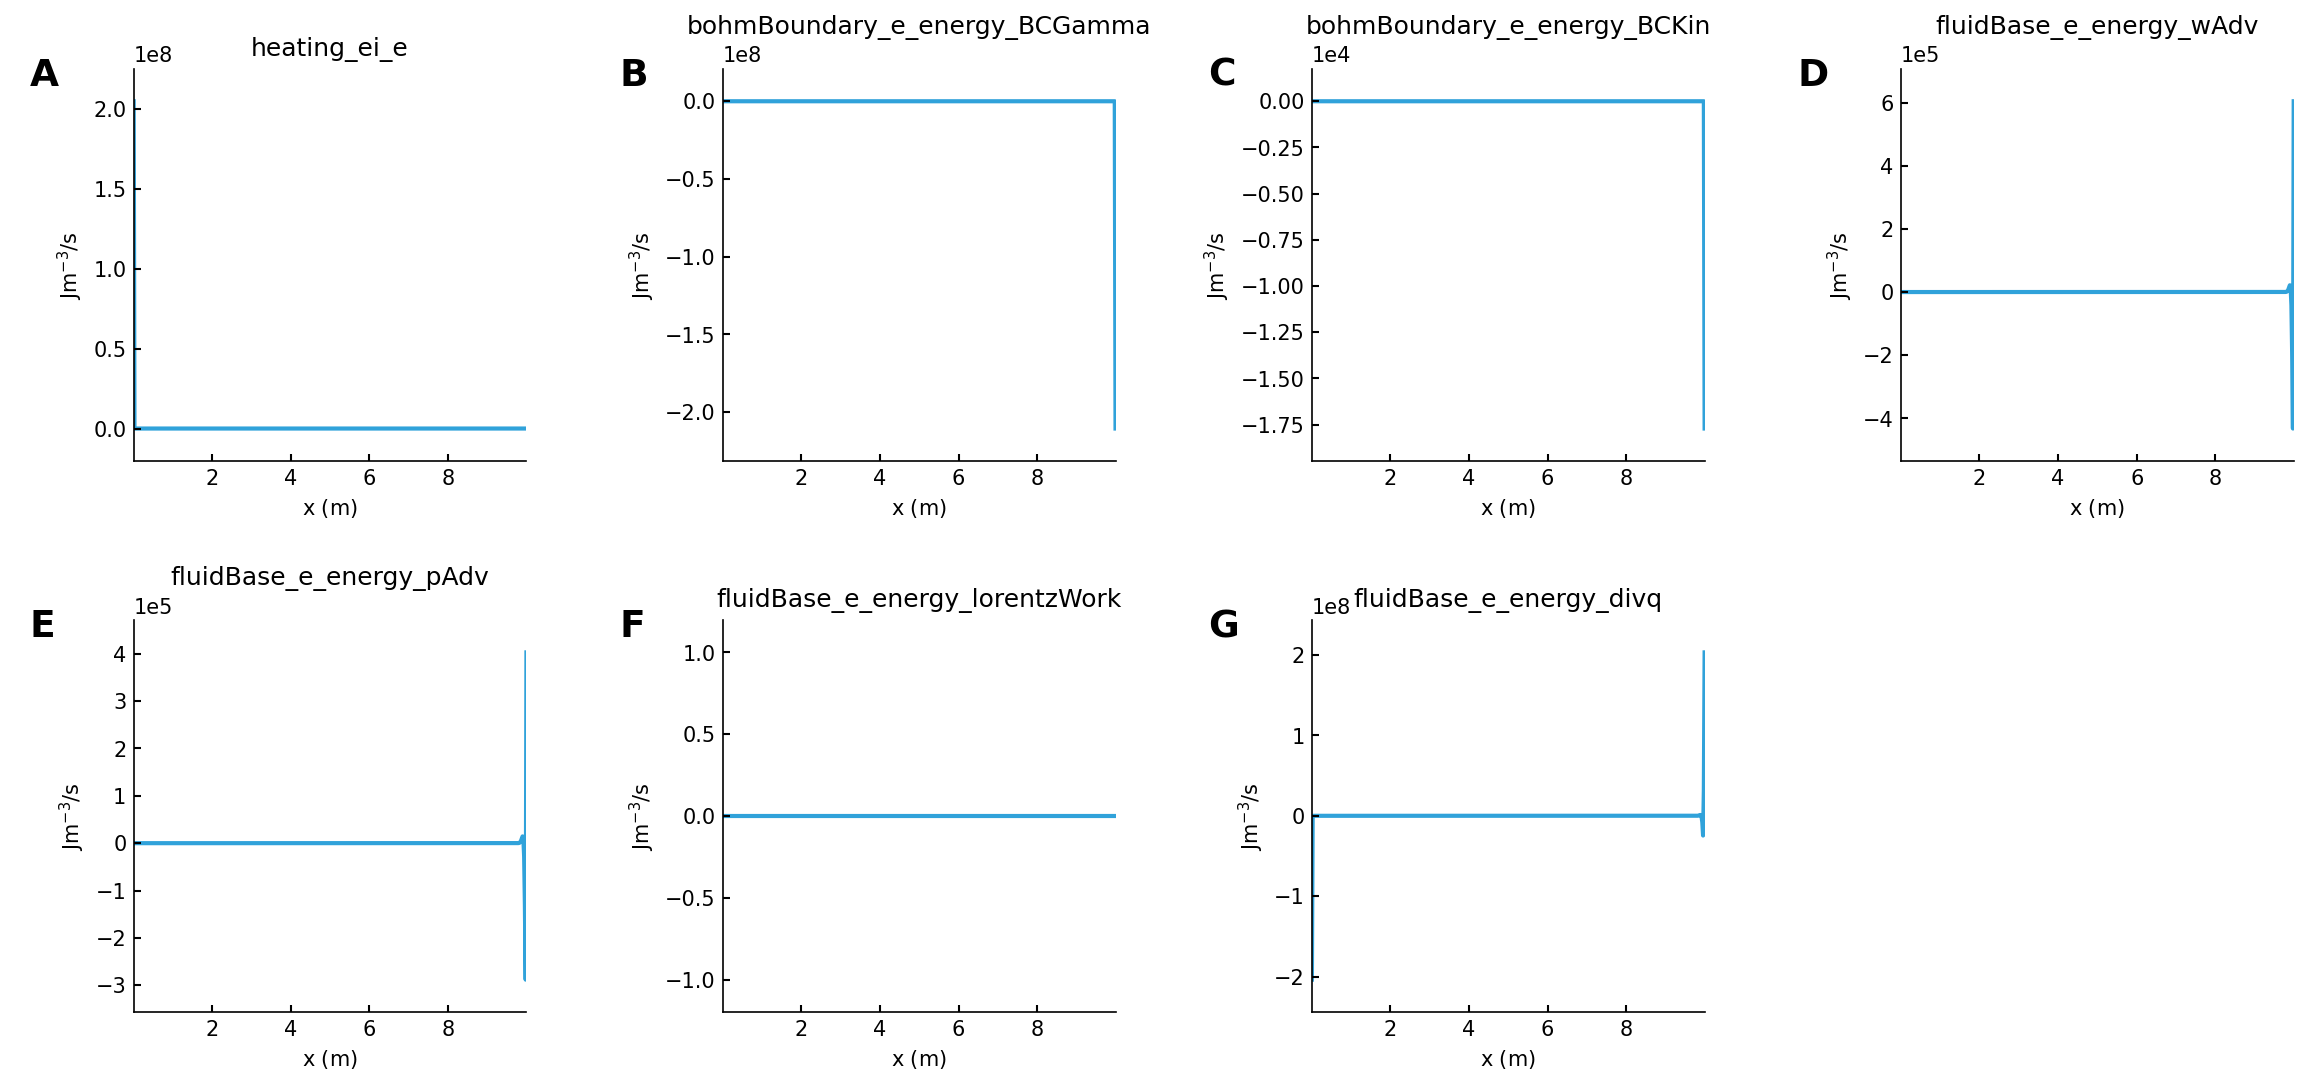

In [ ]:
timeNorm =skn.calculateNorms(10,1e19,1)["time"]
 
varName = "We"
vars = [a+b for a,b in wrapper.getTermsThatEvolveVar(varName)]
curves = [hv.Curve(loadedData[var][{"time":-1}]*loadedData[varName].attrs["normSI"]/timeNorm,label=var).opts(ylabel=loadedData[varName].attrs["unitSI"]+"/s") for var in vars]
layout = hv.Layout(curves)
layout

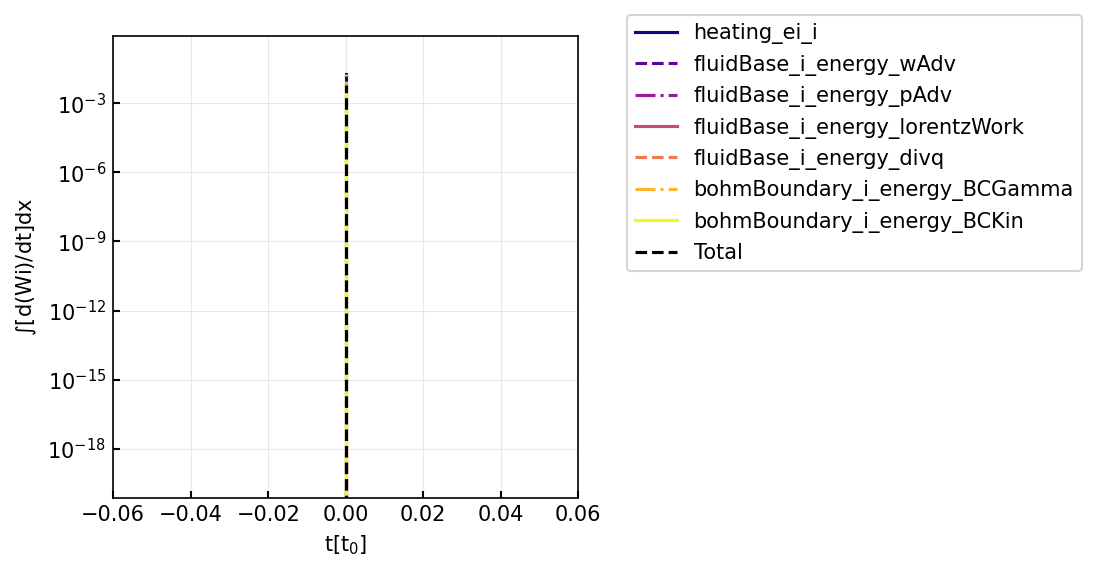

In [ ]:
import RMK_support . analysis_support as ans
_ = ans.termXIntegralPlot(wrapper,loadedData,"Wi",logPlot=True, plotFrom=0)